In [47]:
import os
import random
import re
import time

import pandas as pd
import numpy as np
# import warnings
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 

import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ignore warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

In [183]:
dtrain = pd.read_csv('./input/train.csv')
dtest = pd.read_csv('./input/test.csv')

In [184]:
dtrain.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


<AxesSubplot:>

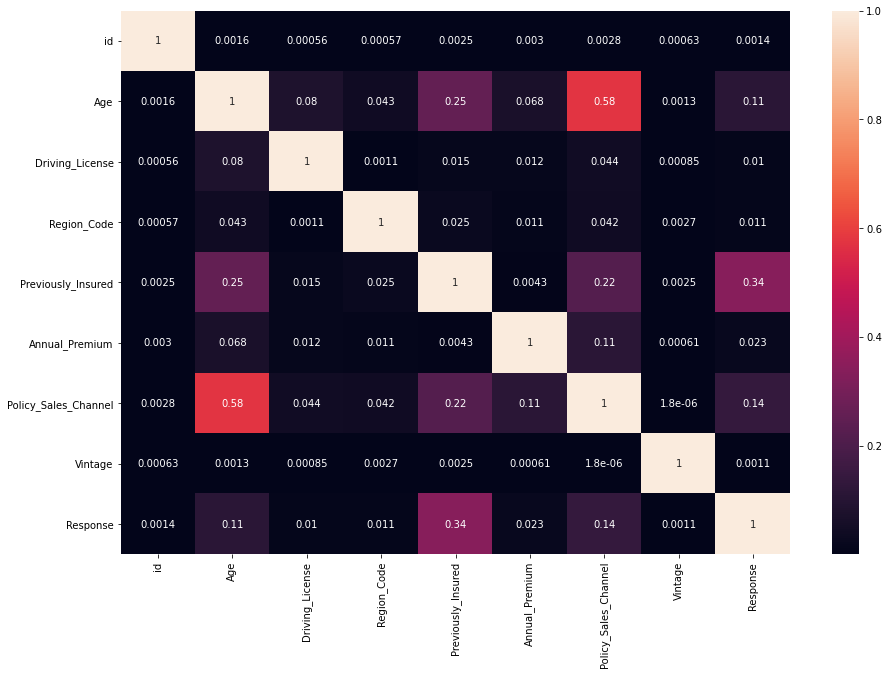

In [185]:
plt.figure(figsize=(15,10))
sns.heatmap(dtrain.corr().abs(), annot=True)

In [186]:
columns_drop = ['Vintage', 'id', 'Region_Code', 'Vintage']
dtrain.drop(columns_drop, axis=1)
dtest.drop(columns_drop, axis=1)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,Male,25,1,1,< 1 Year,No,35786.0,152.0
1,Male,40,1,0,1-2 Year,Yes,33762.0,7.0
2,Male,47,1,0,1-2 Year,Yes,40050.0,124.0
3,Male,24,1,1,< 1 Year,Yes,37356.0,152.0
4,Male,27,1,1,< 1 Year,No,59097.0,152.0
...,...,...,...,...,...,...,...,...
127032,Female,26,1,1,< 1 Year,No,30867.0,152.0
127033,Female,38,1,0,1-2 Year,Yes,28700.0,122.0
127034,Male,21,1,1,< 1 Year,No,29802.0,152.0
127035,Male,71,1,1,1-2 Year,No,62875.0,26.0


In [187]:
from sklearn.preprocessing import LabelEncoder
cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
encoder = LabelEncoder()

encodedtrain = dtrain[cat_features].apply(encoder.fit_transform)
encodedtest = dtest[cat_features].apply(encoder.fit_transform)

In [188]:
other_columns = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Response']
other_columns1 = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel']
dtrain = dtrain[other_columns].join(encodedtrain)
dtest = dtest[other_columns1].join(encodedtrain)

In [189]:
dtest.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Gender,Vehicle_Age,Vehicle_Damage
0,25,1,1,35786.0,152.0,1,2,1
1,40,1,0,33762.0,7.0,1,0,0
2,47,1,0,40050.0,124.0,1,2,1
3,24,1,1,37356.0,152.0,1,1,0
4,27,1,1,59097.0,152.0,0,1,0


In [190]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit(dtrain)
data = scaler.transform(dtrain)
dtrain = pd.DataFrame(data=data, columns=['Age', 'Driving_License', 'Previously,Insured', 'Annual_Premium',
                                      'Policy_Sales_Channel','Response', 'Gender','Vehicle_Age', 'Vehicle_Damage'])
scaler = MinMaxScaler()
data1 = scaler.fit(dtest)
data1 = scaler.transform(dtest)
dtest = pd.DataFrame(data=data1, columns=['Age', 'Driving_License', 'Previously,Insured', 'Annual_Premium',
                                      'Policy_Sales_Channel', 'Gender','Vehicle_Age', 'Vehicle_Damage'])

# Modelagem

In [191]:
N = len(dtrain)
TRAIN_PERC = 0.8
ind_train = np.random.rand(N)  < TRAIN_PERC
train, test = dtrain[ind_train], dtrain[~ind_train]
print(f'len(train)={len(train)}; len(test)={len(test)}')

len(train)=304668; len(test)=76441


In [192]:
X_train = train.drop('Response', axis=1)
y_train = train['Response']
X_test = test.drop('Response', axis=1)
y_test = test['Response']

In [193]:
clf_dict = {
    'KNeighborsClassifier' : KNeighborsClassifier,
    'LogisticRegression': LogisticRegression,
    'MultinomialNB': MultinomialNB,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'SGDClassifier': SGDClassifier,
    'Perceptron': Perceptron,
    'RidgeClassifier': RidgeClassifier,
    'LinearSVC': LinearSVC,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

In [194]:
def get_accuracy(clf, n_estimators=None, max_depth=None, learning_rate=None, max_iter=None):
    start = time.time()
    if clf == KNeighborsClassifier:
        text_clf = clf(params).fit(X_train, y_train)
    else:    
        text_clf = clf(**params).fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    print(f'Accuracy gets in {round(time.time()-start, 2)}s.')
    return np.mean(predicted == y_test)

result_dict = {}

for clf_str, clf_fn in clf_dict.items():
    if clf_str == 'LogisticRegression':
        params = {'max_iter': 200}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': 50,
                'max_depth':10}
    elif clf_str == 'DecisionTreeClassifier':
        params = {'max_depth' : 10}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': 50,
                  'learning_rate': 0.1}
    elif clf_str == 'KNeighborsClassifier':
        params = 10
    else:
        params = {}
    if clf_fn == KNeighborsClassifier:
        accuracy = get_accuracy(clf_fn, params)
    else:
        accuracy = get_accuracy(clf=clf_fn, **params)
    result_dict[clf_str] = accuracy
    print(f'Clf={clf_str}; Accuracy={accuracy}')

Accuracy gets in 272.68s.
Clf=KNeighborsClassifier; Accuracy=0.8714171714132468
Accuracy gets in 2.0s.
Clf=LogisticRegression; Accuracy=0.8771470807550922
Accuracy gets in 0.14s.
Clf=MultinomialNB; Accuracy=0.8771470807550922
Accuracy gets in 0.81s.
Clf=DecisionTreeClassifier; Accuracy=0.8770162609071048
Accuracy gets in 0.62s.
Clf=SGDClassifier; Accuracy=0.8771470807550922
Accuracy gets in 0.34s.
Clf=Perceptron; Accuracy=0.8758519642600175
Accuracy gets in 0.29s.
Clf=RidgeClassifier; Accuracy=0.8771470807550922
Accuracy gets in 6.0s.
Clf=LinearSVC; Accuracy=0.8771470807550922
Accuracy gets in 12.95s.
Clf=RandomForestClassifier; Accuracy=0.8771732447246896
Accuracy gets in 18.27s.
Clf=GradientBoostingClassifier; Accuracy=0.8771470807550922


In [195]:
result_dict = {
    k: v
    for k, v in sorted(
        result_dict.items(),
        key=lambda x: x[1],
        reverse=True
    )
}

result_dict

{'RandomForestClassifier': 0.8771732447246896,
 'LogisticRegression': 0.8771470807550922,
 'MultinomialNB': 0.8771470807550922,
 'SGDClassifier': 0.8771470807550922,
 'RidgeClassifier': 0.8771470807550922,
 'LinearSVC': 0.8771470807550922,
 'GradientBoostingClassifier': 0.8771470807550922,
 'DecisionTreeClassifier': 0.8770162609071048,
 'Perceptron': 0.8758519642600175,
 'KNeighborsClassifier': 0.8714171714132468}

In [196]:
DIM_Logistic = [
    Integer(100, 400, name='max_iter')
]

DIM_SVC = [
    Real(1e-5, 1, name='tol', prior='log-uniform'),
    Real(0.1, 1.5, name='C', prior='log-uniform')
]

DIM_SGDC = [
    Real(1e-5, 1e-2, name='alpha', prior='log-uniform')
]

DIM_RF = [
    Integer(1, 100, name='n_estimators'),
    Integer(5, 30, name='max_depth')
]

DIM_TREE = [
    Integer(5, 30, name='max_depth'),
]

DIMS = {
    'LogisticRegression': DIM_Logistic,
    'LinearSVC': DIM_SVC,
    'SGDClassifier': DIM_SGDC,
    'RandomForestClassifier': DIM_RF,
    'DecisionTreeClassifier': DIM_TREE
}

In [197]:
def optimize(clf_str='LinearSVC'):
    
    dimensions = DIMS[clf_str]
    print(dimensions)
    
    @use_named_args(dimensions=dimensions)
    def fitness(**params):
        clf = clf_dict[clf_str](**params)
        text_clf = clf.fit(X_train, y_train)
        predicted = text_clf.predict(X_test)
        accuracy = np.mean(predicted == y_test)
        print(f'accuracy = {accuracy} with params = {params}')
        return -1.0 *accuracy
    
    res = gp_minimize(func=fitness,
                     dimensions=dimensions,
                     acq_func='EI',
                     n_calls=10,
                     random_state=666)
    print(f'best accuracy={-1.0 * res.fun} with {res.x}')
    return res

In [198]:
res_dict = {}
for clf_str, clf_dim in DIMS.items():
    print(f'start optimizaton for {clf_str}')
    res = optimize(clf_str=clf_str)
    res_dict[clf_str] = res

start optimizaton for LogisticRegression
[Integer(low=100, high=400, prior='uniform', transform='identity')]
accuracy = 0.8771470807550922 with params = {'max_iter': 131}
accuracy = 0.8771470807550922 with params = {'max_iter': 163}
accuracy = 0.8771470807550922 with params = {'max_iter': 139}
accuracy = 0.8771470807550922 with params = {'max_iter': 325}
accuracy = 0.8771470807550922 with params = {'max_iter': 201}
accuracy = 0.8771470807550922 with params = {'max_iter': 173}
accuracy = 0.8771470807550922 with params = {'max_iter': 178}
accuracy = 0.8771470807550922 with params = {'max_iter': 184}
accuracy = 0.8771470807550922 with params = {'max_iter': 239}
accuracy = 0.8771470807550922 with params = {'max_iter': 170}
best accuracy=0.8771470807550922 with [131]
start optimizaton for LinearSVC
[Real(low=1e-05, high=1, prior='log-uniform', transform='identity'), Real(low=0.1, high=1.5, prior='log-uniform', transform='identity')]
accuracy = 0.8771470807550922 with params = {'tol': 3.2590

In [199]:
for clf_str, res in res_dict.items():
    hyperparameters_label = [hp.name for hp in DIMS[clf_str]]
    best_hyperparameters = dict(zip(hyperparameters_label, res.x))
    print(f'clf={clf_str}\nbest accuracy={-res.fun}\nbest hyperparameters={best_hyperparameters}\n')

clf=LogisticRegression
best accuracy=0.8771470807550922
best hyperparameters={'max_iter': 131}

clf=LinearSVC
best accuracy=0.8771470807550922
best hyperparameters={'tol': 3.2590317060358435e-05, 'C': 0.17723383193111547}

clf=SGDClassifier
best accuracy=0.8771470807550922
best hyperparameters={'alpha': 2.031669923181096e-05}

clf=RandomForestClassifier
best accuracy=0.8772779006030795
best hyperparameters={'n_estimators': 27, 'max_depth': 12}

clf=DecisionTreeClassifier
best accuracy=0.8770424248767023
best hyperparameters={'max_depth': 8}



In [200]:
clf_rfc = RandomForestClassifier(n_estimators=27, max_depth=12)
clf_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=27)

In [201]:
predicted = clf_rfc.predict(X_test)
np.mean(predicted == y_test)

0.8771994086942871

In [208]:
clf_rfc.predict(b)

array([0.])

In [207]:
b = np.array([[0.369231, 1, 0, 0.070366, 0.15432, 1, 1, 1]])
b

array([[0.369231, 1.      , 0.      , 0.070366, 0.15432 , 1.      ,
        1.      , 1.      ]])

In [210]:
X_train.head()

,Age,Driving_License,"Previously,Insured",Annual_Premium,Policy_Sales_Channel,Gender,Vehicle_Age,Vehicle_Damage
0,0.369231,1.0,0.0,0.070366,0.154321,1.0,1.0,1.0
1,0.861538,1.0,0.0,0.057496,0.154321,1.0,0.0,0.0
2,0.415385,1.0,0.0,0.066347,0.154321,1.0,1.0,1.0
3,0.015385,1.0,1.0,0.048348,0.932099,1.0,0.5,0.0
4,0.138462,1.0,1.0,0.046259,0.932099,0.0,0.5,0.0


In [144]:
y_train.head()

0    1
2    1
3    0
4    0
5    0
Name: Response, dtype: int64

In [167]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit(X_train)
data = scaler.transform(X_train)

In [168]:
df = pd.DataFrame(data=data, columns=['Age', 'Driving_License', 'Previously,Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Gender','Vehicle_Age', 'Vehicle_Damage'])

In [169]:
df.head()

,Age,Driving_License,"Previously,Insured",Annual_Premium,Policy_Sales_Channel,Gender,Vehicle_Age,Vehicle_Damage
0,0.369231,1.0,0.0,0.070366,0.154321,1.0,1.0,1.0
1,0.415385,1.0,0.0,0.066347,0.154321,1.0,1.0,1.0
2,0.015385,1.0,1.0,0.048348,0.932099,1.0,0.5,0.0
3,0.138462,1.0,1.0,0.046259,0.932099,0.0,0.5,0.0
4,0.061538,1.0,0.0,0.000000,0.981481,0.0,0.5,1.0


In [166]:
dtrain.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Response,Gender,Vehicle_Age,Vehicle_Damage
0,44,1,0,40454.0,26.0,1,1,2,1
1,76,1,0,33536.0,26.0,0,1,0,0
2,47,1,0,38294.0,26.0,1,1,2,1
3,21,1,1,28619.0,152.0,0,1,1,0
4,29,1,1,27496.0,152.0,0,0,1,0
